## 多层感知机实现

In [2]:
import numpy as np
import torch
from matplotlib.pyplot import yscale
from torch import nn
import d2l

In [5]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [6]:
num_inputs, num_outputs, num_hiddens = 784, 10, 256
W1 = nn.Parameter(torch.randn(
num_inputs, num_hiddens, requires_grad=True) * 0.01)
b1 = nn.Parameter(torch.zeros(num_hiddens, requires_grad=True))
W2 = nn.Parameter(torch.randn(
num_hiddens, num_outputs, requires_grad=True) * 0.01)
b2 = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))
params = [W1, b1, W2, b2]

In [5]:
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

In [6]:
def net(X):
    X = X.reshape((-1, num_inputs))
    H = relu(X@W1 + b1) # 这里“@”代表矩阵乘法
    return (H@W2 + b2)

In [7]:
loss = nn.CrossEntropyLoss(reduction='none')

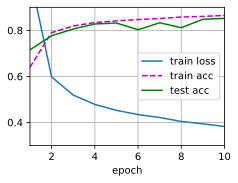

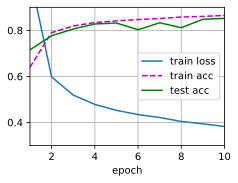

In [8]:
num_epochs, lr = 10, 0.1
updater = torch.optim.SGD(params, lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, updater)

In [16]:
import torch
from torch import nn
import d2l
import numpy as np
import math

In [8]:
net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(num_inputs, num_hiddens),
    nn.ReLU(),
    nn.Linear(num_hiddens, num_outputs)
)

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, mean=0, std=0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=10, bias=True)
)

In [9]:
batch_size, lr, num_epochs = 256, 0.1, 10
loss = nn.CrossEntropyLoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=lr)

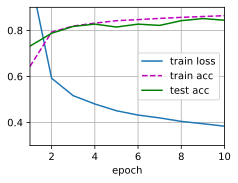

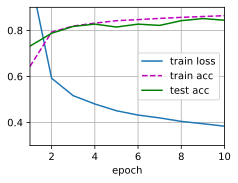

In [10]:
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

使用以下三阶多项式来生成训练和测试数据的标签：
$$
y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6\frac{x^3}{3!} + \epsilon, \;\; \epsilon \sim N(0, 0.1^2)
$$

In [11]:
# 一共有20个特征，但只有最前面4个有意义
max_degree = 20
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配特征空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size = (n_train + n_test, 1))
np.random.shuffle(features)
# np.power(x1, x2)，其中x1是底数，x2是指数
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1) #gamma(n) = (n-1)!
# labels 的维度：(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [13]:
# Numpy ndarray 转换为 tensor
true_w, features, poly_features, labels = [
    torch.tensor(x, dtype=torch.float) for x in
        [true_w, features, poly_features, labels]
]

In [14]:
features[:2], poly_features[:2], labels[:2]

(tensor([[ 0.3544],
         [-1.0276]]),
 tensor([[ 1.0000e+00,  3.5444e-01,  6.2813e-02,  7.4211e-03,  6.5757e-04,
           4.6614e-05,  2.7536e-06,  1.3943e-07,  6.1772e-09,  2.4327e-10,
           8.6224e-12,  2.7783e-13,  8.2060e-15,  2.2373e-16,  5.6642e-18,
           1.3384e-19,  2.9649e-21,  6.1815e-23,  1.2172e-24,  2.2706e-26],
         [ 1.0000e+00, -1.0276e+00,  5.2800e-01, -1.8086e-01,  4.6464e-02,
          -9.5495e-03,  1.6355e-03, -2.4010e-04,  3.0842e-05, -3.5215e-06,
           3.6187e-07, -3.3806e-08,  2.8950e-09, -2.2884e-10,  1.6797e-11,
          -1.1507e-12,  7.3908e-14, -4.4676e-15,  2.5506e-16, -1.3795e-17]]),
 tensor([5.1340, 0.9867]))

In [21]:
def evaluate_loss(net, data_iter, loss):
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)  # 损失的总和，样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [25]:
# 训练函数
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]

    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array(
        (train_features, train_labels.reshape(-1, 1)), batch_size
    )
    test_iter = d2l.load_array(
        (test_features, test_labels.reshape(-1, 1)), batch_size, is_train=False
    )
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(
        xlabel='epoch', ylabel='loss', yscale='log',
        xlim=[1, num_epochs], ylim=[1e-3, 1e2],
        legend=['train', 'test']
    )
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1,
                         (evaluate_loss(net, train_iter, loss),
                          evaluate_loss(net, test_iter, loss))
                         )
    print('weight: ', net[0].weight.data.numpy())

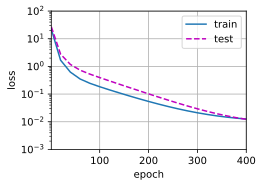

weight:  [[ 5.0018883  1.3009595 -3.4008944  5.356073 ]]


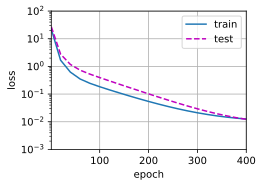

In [26]:
"""我们将首先使用三阶多项式函数，它与数据生成函数的阶数相同。结果表明，该模型能有效降低训练损失和测试损失"""
# 从多项式特征中选择前4个维度，即 1, x, x^2/2!, x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

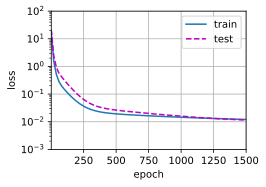

weight:  [[ 4.968993    1.257421   -3.2638295   5.3410993  -0.33886865  0.9718358
  -0.13658202 -0.0217156  -0.1793136   0.02811069  0.21995297  0.08734334
   0.11933062  0.04009082  0.18104887 -0.04670703  0.0998112  -0.20541207
   0.15437333  0.08828371]]


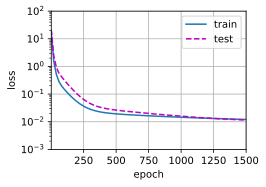

In [27]:
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)

$L_2$ 正则化线性模型构成经典的岭回归（ridge regression）算法， $L_1$ 正则化线性回归是统计学中类似的基本模型，通常被称为套索回归（lasso regression）。**使用 $L_2$ 范数的一个原因是它对权重向量的大分量施加了巨大的惩罚**。这使得我们的学习算法偏向于在大量特征上均匀分布权重的模型。在实践中，这可能使它们对单个变量中的观测误差更为稳定。相比之下，**$L_1$ 惩罚会导致模型将权重集中在一小部分特征上，而将其他权重清除为零。这称为特征选择（feature selection），这可能是其他场景下需要的**。

回顾线性回归中，我们的损失由下式给出：
$$
L(\boldsymbol{w}, b) = \dfrac{1}{n}\sum\limits^n_{i=1}\dfrac{1}{2}\left(\boldsymbol{w}^T\boldsymbol{x}^{(i)} + b - y^{(i)} \right)^2.
$$
为了惩罚权重向量的大小，我们必须以某种方式在损失函数中添加 $\|\boldsymbol{w}\|^2$。如
$$
L(\boldsymbol{w}, b) + \dfrac{\lambda}{2}\|\boldsymbol{w}\|^2,
$$

$\lambda$ 越大，我们对 $\boldsymbol{w}$ 的限制也越大。而使用 $L_2$ 范式而非自然平方（也即前面加一个 $1/2$ 的常数）是为了求梯度后消去。这样更新参数中对 $\boldsymbol{w}$ 的惩罚则仅取决于 $\eta$ 和 $\lambda$（当然还取决于 $\boldsymbol{w}$）两个参数。因此我们更新 $L_2$ 正则化回归的小批量随机梯度下降更新如下式：
$$
\boldsymbol{w} \leftarrow (1 - \eta\lambda)\boldsymbol{w} - \dfrac{\eta}{|\mathcal{B}|}\sum\limits_{i \in \mathcal{B}}\boldsymbol{x}^{(i)}\left(\boldsymbol{w}^T\boldsymbol{x}^{(i)} + b - y^{(i)} \right).
$$


In [28]:
%matplotlib inline
import torch
from torch import nn
import d2l

首先，我们像以前一样生成一些数据，生成公式如下：
$$
y = 0.05 + \sum^d_{i=1}0.01 x_i + \epsilon, \;\; \epsilon\in N(0, 0.01^2)
$$
为了使过拟合的效果更加明显，我们可以将问题的维数增加到d = 200，并使用一个只包含20个样本的小训练集。

In [46]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

In [47]:
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

In [48]:
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

In [35]:
def train_weights_decay(params_lambda):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(
        xlabel='epochs', ylabel='loss', yscale='log',
        xlim=[5, num_epochs], legend = ['train', 'test']
    )
    for epoch in range(num_epochs):
        for X,y in train_iter:
            # 增加了L2范数惩罚项，
            # 广播机制使 l2_penalty(w) 成为一个长度为 batch_size 的向量
            l = loss(net(X), y) + params_lambda * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1,
                         (evaluate_loss(net, train_iter, loss),
                           evaluate_loss(net, test_iter, loss)))
    print('w 的 L2 范数是：',torch.norm(w).item())

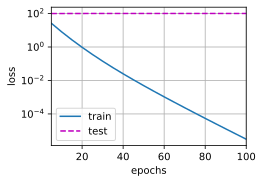

w 的 L2 范数是： 12.799764633178711


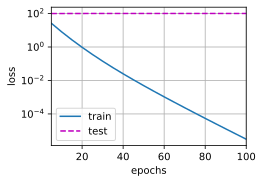

In [36]:
train_weights_decay(0)

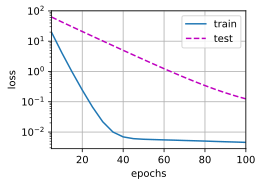

w 的 L2 范数是： 0.39174336194992065


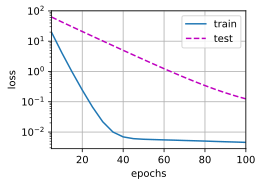

In [37]:
train_weights_decay(3)

In [70]:
def train_weights_decay_concise(params_lambda):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    # 偏置参数没有衰减
    trainer = torch.optim.SGD([
        {"params": net[0].weight, 'weight_decay': params_lambda},
        {"params": net[0].bias}
    ], lr=lr)
    animator = d2l.Animator(
        xlabel='epochs', ylabel='loss', yscale='log',
        xlim=[5, num_epochs], legend = ['train', 'test']
    )
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1,
                         (d2l.evaluate_loss(net, train_iter, loss),
                          d2l.evaluate_loss(net, test_iter, loss)))

    print("w的L2范数： ", net[0].weight.norm().item())

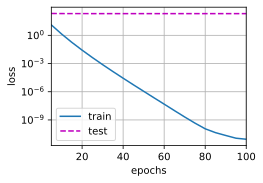

w的L2范数：  14.529406547546387


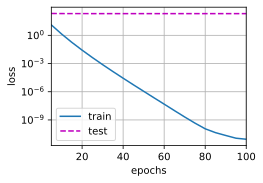

In [71]:
train_weights_decay_concise(0)

In [51]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    # 偏置参数没有衰减
    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay': wd},
        {"params":net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
        xlim=[5, num_epochs], legend=['train','test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1,
            (d2l.evaluate_loss(net, train_iter, loss),
            d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())

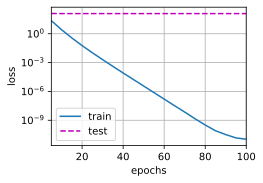

w的L2范数： 12.04516887664795


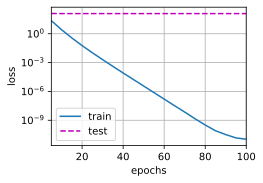

In [52]:
train_concise(0)

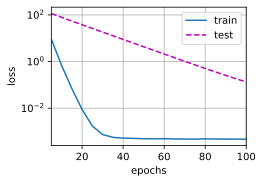

w的L2范数： 0.3529379069805145


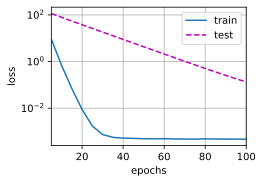

In [53]:
train_concise(3)

## 暂退法(Dropout)实现

In [72]:
import torch
from torch import nn
import d2l

In [79]:
def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    # 在 dropout == 1 情况下，所有元素都被丢弃
    if dropout == 1:
        return torch.zeros_like(X)
    # 在 dropout == 0 情况下，所有元素都被保留
    if dropout == 0:
        return X
    mask = (torch.rand(X.shape) > dropout).float()
    # 以dropout的概率丢弃张量输入X中的元素，
    # 然后重新放缩剩余部分：将剩余部分除以 1.0-dropout
    return mask * X / (1 - dropout)

In [80]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

In [81]:
# 我们可以将暂退法应用于每个隐藏层的输出（在激活函数之后），并且可以为每一层分别设置暂退概率：
# 常见的技巧是在靠近输入层的地方设置较低的暂退概率。

dropout1, dropout2 = 0.2, 0.5

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2, is_training=True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((-1, self.num_inputs))))
        # 只有在训练模型时才使用 dropout
        if self.training == True:
            # 在第一个全连接层之后添加一个 dropout 层
            H1 = dropout_layer(H1, dropout1)
        H2 = self.relu(self.lin2(H1))
        if self.training == True:
            # 在第二个全连接层之后添加一个 dropout 层
            H2 = dropout_layer(H2, dropout2)
        out = self.lin3(H2)
        return out


net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2, is_training=False)

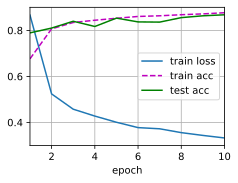

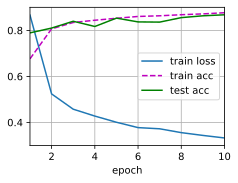

In [82]:
num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss(reduction='none')
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

In [86]:
net = nn.Sequential(nn.Flatten(), # nn.Flatten() 是 PyTorch 中 torch.nn 模块里的一个层，
                                  # 其主要功能是把输入数据展平成一维向量。
                    nn.Linear(num_inputs, num_hiddens1),
                    nn.ReLU(),
                    # 在第一个全连接层后添加一个 dropout 层
                    nn.Dropout(dropout1),
                    nn.Linear(num_hiddens1, num_hiddens2),
                    nn.ReLU(),
                    nn.Dropout(dropout2),
                    nn.Linear(num_hiddens2, num_outputs)
                    )

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.5, inplace=False)
  (7): Linear(in_features=256, out_features=10, bias=True)
)

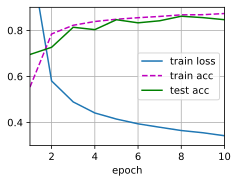

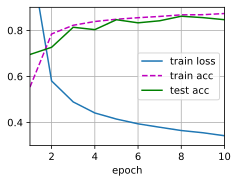

In [87]:
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

## 预测房价

In [90]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
import d2l

In [117]:
DATA_URL = "http://d2l-data.s3-accelerate.amazonaws.com/"

DATA_HUB["kaggle_house_train"] = (
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce'
)

DATA_HUB['kaggle_house_test'] = (
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90'
)

In [118]:
train_data = pd.read_csv(d2l.download("kaggle_house_train"))
test_data = pd.read_csv(d2l.download("kaggle_house_test"))

In [119]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [120]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [121]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

首先进行数据预处理，这包括：
1. 将所有缺失的值替换为相应特征的平均值。
2. 为了将所有特征放在一个共同的尺度上，我们通过将特征重新缩放到零均值和单位方差来标准化数据：
   $$
   x \leftarrow \dfrac{x - \mu}{\sigma},
   $$
   现在这些特征具有零均值和单位方差，即
   $$
   \begin{aligned}
   E\left[\frac{x - \mu}{\sigma}\right] = \dfrac{\mu - \mu}{\sigma} = 0, && E[(x - \mu)^2] = E[x^2 - 2x\mu + \mu^2] = (\sigma^2 + \mu^2) - 2\mu^2 + \mu^2 = \sigma^2
   \end{aligned}
   $$
   我们标准化数据有两个原因：首先，它方便优化。其次，因为我们不知道哪些特征是相关的，所以我们不想让惩罚分配给一个特征的系数比分配给其他任何特征的系数更大。

In [124]:
# 若无法获得测试数据，则可根据训练数据计算均值和标准差
numeric_features = all_features.dtypes[all_features.dtypes != 'object_'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 在标准化数据之后，所有均值消失，因此我们可以将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

# 将离散值替换为独热编码
# “Dummy_na=True”将“na”（缺失值）视为有效的特征值，并为其创建指示符特征
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 330)

In [125]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

In [126]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features,1))
    return net

In [127]:
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    # torch.clamp 是 PyTorch 中的一个函数，用于对输入的张量中的每个元素进行裁剪操作，将元素的值限制在指定的区间内。这在很多深度学习场景中非常有用，比如防止梯度爆炸、限制输出值范围等。
    # torch.clamp(input, min=None, max=None, out=None)
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

In [128]:
# 我们的训练函数将借助Adam优化器。Adam优化器的主要吸引力在于它对初始学习率不那么敏感。
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate,
                                 weight_decay=weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        # 在每一轮批量完成后，计算当前轮次训练/测试集上的对数均方根误差
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [129]:
# 使用K折交叉验证，它有助于模型选择和超参数调整
def get_k_fold_data(k, i, X, y):
    """
    :param k: 表示 K 折交叉验证中的折数，必须是大于 1 的整数。
    :param i: 表示当前使用的验证集的索引，取值范围是 0 到 k - 1。
    :param X: 输入的特征数据，是一个 PyTorch 张量，通常形状为 (样本数量, 特征数量)。
    :param y: 输入的标签数据，是一个 PyTorch 张量，通常形状为 (样本数量,)。
    :return:
    """
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        # 使用 slice 函数创建一个切片对象，用于从数据集中提取第 j 折的数据。
        idx = slice(j * fold_size, (j + 1) * fold_size)
        # 根据切片对象 idx 从特征数据 X 和标签数据 y 中提取第 j 折的数据
        X_part, y_part = X[idx,:], y[idx]
        # 若 j==i，则将其作为验证集
        if j == i:
            X_valid, y_valid = X_part, y_part
        # 若训练集还未初始化，则将当前折的数据作为训练集的初始数据
        elif X_train is None:
            X_train, y_train = X_part, y_part
        # 如果训练集已有数据，则使用 torch.cat 函数将当前折数据与已有训练集数据按行拼接起来
        else:
            X_train = torch.cat((X_train, X_part), dim=0)
            y_train = torch.cat((y_train, y_part), dim=0)
    return X_train, y_train, X_valid, y_valid

In [130]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        # *data是将元组解包作为参数传递给 train 函数
        # train_ls, valid_ls 分别是训练过程中每一轮的训练损失和验证损失列表
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        # 每一折训练结束时将最后一次训练的训练损失 train_ls[-1] 和 验证损失 valid_ls[-1] 累加
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        # 绘制第一折的训练损失和验证损失随轮数变化的曲线
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        # 打印每一折训练结束时的训练损失和验证损失，方便用户直观了解模型在每一折上的性能。
        print(f"折{i + 1}，训练 log rmse {float(train_ls[-1]):f},"
              f"验证 log rmse {float(valid_ls[-1]):f}")
    return train_l_sum / k, valid_l_sum / k

折1，训练 log rmse 7.833755,验证 log rmse 8.332644
折2，训练 log rmse 7.743814,验证 log rmse 8.206345
折3，训练 log rmse 7.977288,验证 log rmse 8.420081
折4，训练 log rmse 7.889685,验证 log rmse 8.425148
折5，训练 log rmse 7.956882,验证 log rmse 8.390936
5-折验证：平均训练 log rmse: 7.880285平均验证log rmse: 8.355031


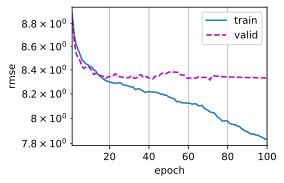

In [131]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(
    k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size
)
print(f"{k}-折验证：平均训练 log rmse: {float(train_l):f}，"
      f'平均验证log rmse: {float(valid_l):f}')

有时一组超参数的训练误差可能非常低，但K折交叉验证的误差要高得多，这表明模型过拟合了。在整个训练过程中，我们希望监控训练误差和验证误差这两个数字。较少的过拟合可能表明现有数据可以支撑一个更强大的模型，较大的过拟合可能意味着我们可以通过正则化技术来获益。